In [1]:
!pip install lightning[extra]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 14.6 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=524e9b8031de2fb3135d11e7b51d54506a05c

In [1]:
import os
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Optional, Union
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_and_extract_archive
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

In [4]:
import shutil

In [9]:
!pip install timm  # Make sure timm is installed: pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.3 MB/s eta 0:00:00


DATA MODULE

In [5]:
class DogsDataModule(pl.LightningDataModule):
    def __init__(self, dl_path: str = "data", batch_size: int = 32,num_workers: int = 0):
        super().__init__()
        self._dl_path = Path(dl_path)
        self._batch_size = batch_size
        self._num_workers = num_workers
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.num_classes = None

    def prepare_data(self):
        """Download images and prepare datasets."""
        dataset_dir = self._dl_path.joinpath("dataset")
        print(f"Checking for dataset in: {dataset_dir}")

        # Check if the dataset already exists
        if not dataset_dir.exists():
            download_and_extract_archive(
                url="https://raw.githubusercontent.com/abhiyagupta/Datasets/refs/heads/main/CNN_Datasets/dogs_classifier_dataset.zip",
                download_root=self._dl_path,
                remove_finished=True
            )

    def setup(self, stage: Optional[str] = None):
        """Load data and split into train, val, test sets."""
        print("Setting up data...")
        dataset_df = self.create_dataframe()
        print(f"Total images found: {len(dataset_df)}")

        self.num_classes = dataset_df['label'].nunique()
        print(f"Number of unique classes: {self.num_classes}")

        train_df, temp_df = self.split_train_temp(dataset_df)
        val_df, test_df = self.split_val_test(temp_df)

        print(f"Train set size: {len(train_df)}")
        print(f"Validation set size: {len(val_df)}")
        print(f"Test set size: {len(test_df)}")



        # create input folder:
        input_folder = Path("input")
        if not input_folder.exists():
            input_folder.mkdir(parents=True)

        for _, row in val_df.iterrows():
            src_path = self._dl_path.joinpath("dataset", row['image_path'])
            dst_path = input_folder.joinpath(row['image_path'].split('/')[-1])
            shutil.copy(src_path, dst_path)

        print(f"Validation images saved to: {input_folder.absolute()}")







        self.train_dataset = self.create_dataset(train_df)
        self.val_dataset = self.create_dataset(val_df)
        self.test_dataset = self.create_dataset(test_df)

        print(f"Length of validation dataset: {len(self.val_dataset)}")

    def create_dataframe(self):
        DATASET_PATH = self._dl_path.joinpath("dataset")
        print(f"Looking for images in: {DATASET_PATH}")
        IMAGE_PATH_LIST = list(DATASET_PATH.glob("*/*.jpg"))
        print(f"Number of images found: {len(IMAGE_PATH_LIST)}")
        images_path = [str(img_path.relative_to(DATASET_PATH)) for img_path in IMAGE_PATH_LIST]
        labels = [img_path.parent.name for img_path in IMAGE_PATH_LIST]

        df = pd.DataFrame({'image_path': images_path, 'label': labels})
        print(f"Number of unique labels: {df['label'].nunique()}")
        print(df.head())
        return df




    def get_num_classes(self):
        if self.num_classes is None:
            raise ValueError("Number of classes is not set. Make sure setup() method is called.")
        return self.num_classes

    def split_train_temp(self, df):
        train_split_idx, temp_split_idx, _, _ = (
            train_test_split(
                df.index,
                df.label,
                test_size=0.30,
                stratify=df.label,
                random_state=42
            )
        )
        return df.iloc[train_split_idx].reset_index(drop=True), df.iloc[temp_split_idx].reset_index(drop=True)

    def split_val_test(self, df):
        val_split_idx, test_split_idx, _, _ = (
            train_test_split(
                df.index,
                df.label,
                test_size=0.5,
                stratify=df.label,
                random_state=42
            )
        )
        return df.iloc[val_split_idx].reset_index(drop=True), df.iloc[test_split_idx].reset_index(drop=True)

    def create_dataset(self, df):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return CustomImageDataset(
            root=str(self._dl_path.joinpath("dataset")),
            image_paths=df['image_path'],
            transform=transform
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self._batch_size, num_workers=self._num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self._batch_size, num_workers=self._num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self._batch_size, num_workers=self._num_workers, shuffle=False)


class CustomImageDataset(Dataset):  # Change this line
    def __init__(self, root, image_paths, transform=None):
        self.root = root
        self.image_paths = image_paths
        self.transform = transform
        self.images = []
        self.labels = []

        for idx, path in enumerate(image_paths):
            img = Image.open(os.path.join(root, path))
            self.images.append(img)
            self.labels.append(idx)  # Assuming labels are indices

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        if self.transform:
            img = self.transform(img)

        return img, label

# checking data module

In [6]:
# call class created above
dm = DogsDataModule()
dm.prepare_data()
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()


Checking for dataset in: data/dataset
Setting up data...
Looking for images in: data/dataset
Number of images found: 967
Number of unique labels: 10
             image_path   label
0  Beagle/Beagle_45.jpg  Beagle
1  Beagle/Beagle_63.jpg  Beagle
2  Beagle/Beagle_24.jpg  Beagle
3  Beagle/Beagle_12.jpg  Beagle
4  Beagle/Beagle_60.jpg  Beagle
Total images found: 967
Number of unique classes: 10
Train set size: 676
Validation set size: 145
Test set size: 146
Validation images saved to: /content/input
Length of validation dataset: 145


In [7]:
len(val_loader)

5

In [8]:
df_train=dm.train_dataloader()
print(df_train)

MODEL ARCHITECTURE

In [10]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
import timm  # Make sure timm is installed: pip install timm

class DogsClassifier(pl.LightningModule):
    def __init__(self, lr: float = 1e-3, num_classes: int = 10):
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

        # Load pre-trained ResNet18 model, adjusting the final layer for 10 classes
        self.model = timm.create_model('resnet18', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, labels = batch

        # Check for and correct out-of-bounds labels during training
        labels = torch.clamp(labels, 0, self.num_classes - 1)

        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch

        # Check for and correct out-of-bounds labels during validation
        labels = torch.clamp(labels, 0, self.num_classes - 1)

        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        # Check for and correct out-of-bounds labels during validation
        labels = torch.clamp(labels, 0, self.num_classes - 1)

        outputs = self(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss


In [11]:
# view model architecture
model = DogsClassifier()
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

DogsClassifier(
  (criterion): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
      

TRAIN.py

In [12]:
import sys
# sys.path.append('/app')

import os
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
# from data_module.dogs_datamodule import DogsDataModule
# from model.dogs_classifier import DogsClassifier
import time

def main():
    # Create data module
    data_module = DogsDataModule(dl_path='./data', batch_size=32)

    # Explicitly call prepare_data and setup
    data_module.prepare_data()
    data_module.setup()

    # Get the number of classes
    num_classes = data_module.get_num_classes()
    print(f"Number of classes in the dataset: {num_classes}")

    print("#########################")

    # Create model
    model = DogsClassifier(num_classes=num_classes, lr=1e-3)

    # Setup logging
    logger = TensorBoardLogger("logs", name="dogs_classifier")

    # Ensure directory exists
    checkpoint_dir = '/app/checkpoints/'
    if not os.path.exists(checkpoint_dir):
       os.makedirs(checkpoint_dir)



    # Setup checkpointing
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',         # Save model with the best validation loss
        dirpath= checkpoint_dir,     # Directory where checkpoints will be saved
        filename='dogs_classifier-{epoch:02d}-{val_loss:.2f}',  # Checkpoint filename format
        save_top_k=1,               # Save only the best model
        mode='min',                 # 'min' because we want the minimum validation loss
    )

    # Create trainer
    trainer = pl.Trainer(
        max_epochs=1,
        logger=logger,
        callbacks=[checkpoint_callback, RichProgressBar()],
        accelerator='auto',
    )

    print("trainer created")

    # Train the model
    trainer.fit(model, data_module)

if __name__ == "__main__":
    main()

Checking for dataset in: data/dataset
Setting up data...
Looking for images in: data/dataset
Number of images found: 967
Number of unique labels: 10
             image_path   label
0  Beagle/Beagle_45.jpg  Beagle
1  Beagle/Beagle_63.jpg  Beagle
2  Beagle/Beagle_24.jpg  Beagle
3  Beagle/Beagle_12.jpg  Beagle
4  Beagle/Beagle_60.jpg  Beagle
Total images found: 967
Number of unique classes: 10
Train set size: 676
Validation set size: 145
Test set size: 146
Validation images saved to: /content/input
Length of validation dataset: 145
Number of classes in the dataset: 10
#########################


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


trainer created
Checking for dataset in: data/dataset
Setting up data...
Looking for images in: data/dataset
Number of images found: 967
Number of unique labels: 10
             image_path   label
0  Beagle/Beagle_45.jpg  Beagle
1  Beagle/Beagle_63.jpg  Beagle
2  Beagle/Beagle_24.jpg  Beagle
3  Beagle/Beagle_12.jpg  Beagle
4  Beagle/Beagle_60.jpg  Beagle
Total images found: 967
Number of unique classes: 10
Train set size: 676
Validation set size: 145
Test set size: 146
Validation images saved to: /content/input
Length of validation dataset: 145


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ criterion │ CrossEntropyLoss   │      0 │ train │
│ 1 │ accuracy  │ MulticlassAccuracy │      0 │ train │
│ 2 │ model     │ ResNet             │ 11.2 M │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 96                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches 
(22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [14]:
checkpoint = torch.load('/app/checkpoints/dogs_classifier-epoch=00-val_loss=0.54.ckpt')
print(checkpoint['state_dict'].keys())  # Check the keys and shapes in the state_dict

<ipython-input-14-0b11e8a446f8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/app/checkpoints/dogs_classifier-epoch=00-val_loss=0.54.ckpt')


odict_keys(['model.conv1.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.bn1.num_batches_tracked', 'model.layer1.0.conv1.weight', 'model.layer1.0.bn1.weight', 'model.layer1.0.bn1.bias', 'model.layer1.0.bn1.running_mean', 'model.layer1.0.bn1.running_var', 'model.layer1.0.bn1.num_batches_tracked', 'model.layer1.0.conv2.weight', 'model.layer1.0.bn2.weight', 'model.layer1.0.bn2.bias', 'model.layer1.0.bn2.running_mean', 'model.layer1.0.bn2.running_var', 'model.layer1.0.bn2.num_batches_tracked', 'model.layer1.1.conv1.weight', 'model.layer1.1.bn1.weight', 'model.layer1.1.bn1.bias', 'model.layer1.1.bn1.running_mean', 'model.layer1.1.bn1.running_var', 'model.layer1.1.bn1.num_batches_tracked', 'model.layer1.1.conv2.weight', 'model.layer1.1.bn2.weight', 'model.layer1.1.bn2.bias', 'model.layer1.1.bn2.running_mean', 'model.layer1.1.bn2.running_var', 'model.layer1.1.bn2.num_batches_tracked', 'model.layer2.0.conv1.weight', 'model.layer2.0.bn1.w

EVAL>py

In [15]:
# import torch
# from model.dogs_classifier import DogsClassifier
# from data_module.dogs_datamodule import DogsDataModule
# import pytorch_lightning as pl

def evaluate():
    data_module = DogsDataModule('./data')  # Ensure data path is correct
    model = DogsClassifier.load_from_checkpoint('/app/checkpoints/dogs_classifier-epoch=00-val_loss=0.54.ckpt', strict=False)

    # Use accelerator='gpu' or accelerator='auto' instead of gpus
    trainer = pl.Trainer(accelerator='auto')
    trainer.test(model, datamodule=data_module)

if __name__ == '__main__':
    evaluate()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Checking for dataset in: data/dataset
Setting up data...
Looking for images in: data/dataset
Number of images found: 967
Number of unique labels: 10
             image_path   label
0  Beagle/Beagle_45.jpg  Beagle
1  Beagle/Beagle_63.jpg  Beagle
2  Beagle/Beagle_24.jpg  Beagle
3  Beagle/Beagle_12.jpg  Beagle
4  Beagle/Beagle_60.jpg  Beagle
Total images found: 967
Number of unique classes: 10
Train set size: 676
Validation set size: 145
Test set size: 146
Validation images saved to: /content/input
Length of validation dataset: 145


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9383561611175537     │
│         test_loss         │    0.5975279808044434     │
└───────────────────────────┴───────────────────────────┘

INFER.py

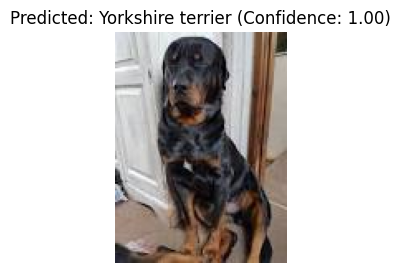

Processed Rottweiler_95.jpg: Predicted Yorkshire Terrier with confidence 1.00
Output saved to output/Rottweiler_95_prediction.png


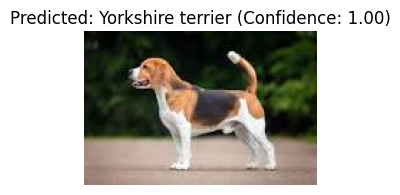

Processed Beagle_43.jpg: Predicted Yorkshire Terrier with confidence 1.00
Output saved to output/Beagle_43_prediction.png


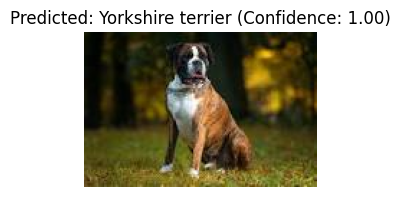

Processed Boxer_54.jpg: Predicted Yorkshire Terrier with confidence 1.00
Output saved to output/Boxer_54_prediction.png


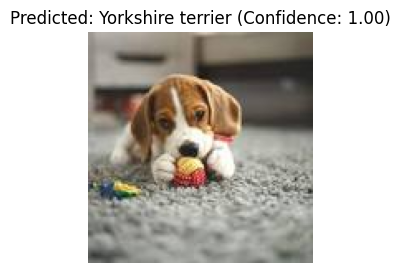

Processed Beagle_54.jpg: Predicted Yorkshire Terrier with confidence 1.00
Output saved to output/Beagle_54_prediction.png


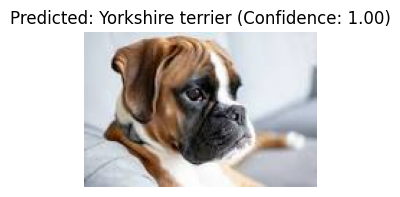

Processed Boxer_83.jpg: Predicted Yorkshire Terrier with confidence 1.00
Output saved to output/Boxer_83_prediction.png


In [19]:
import os
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image as PILImage
from pathlib import Path

def inference(model, image_path, output_path):
    # Load and preprocess the image
    img = PILImage.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply the transform to the image
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Move the input tensor to the same device as the model
    img_tensor = img_tensor.to(model.device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Get class labels (you need to provide these based on your specific dog breeds)
    class_labels = ["Beagle", "Boxer", "BullDog", "Dachshund", "German Shepard",
                    "Golder Retriever", "Labrador Retriver", "Poodle", "Rottweilier", "Yorkshire Terrier"]
    predicted_label = class_labels[predicted_class]
    confidence = probabilities[0][predicted_class].item()

    # Visualize the prediction
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label.capitalize()} (Confidence: {confidence:.2f})')

    # Display the figure
    plt.show()

    # Save the figure to the output folder
    plt.savefig(output_path)
    plt.close()

    return predicted_label, confidence

def main():
    # Set up input and output folders
    input_folder = Path("input")
    output_folder = Path("output")

    # Create output folder if it doesn't exist
    output_folder.mkdir(exist_ok=True)

    # Load the model
    model = DogsClassifier.load_from_checkpoint('/app/checkpoints/dogs_classifier-epoch=00-val_loss=0.54.ckpt', strict=False)
    model.eval()

    # Get all image files from the input folder
    image_files = list(input_folder.glob('*.jpg')) + list(input_folder.glob('*.png'))

    # Randomly select 5 images (or all if less than 5)
    selected_images = random.sample(image_files, min(5, len(image_files)))

    # Process each selected image
    for img_path in selected_images:
        output_path = output_folder / f"{img_path.stem}_prediction.png"
        predicted_label, confidence = inference(model, img_path, output_path)
        print(f"Processed {img_path.name}: Predicted {predicted_label} with confidence {confidence:.2f}")
        print(f"Output saved to {output_path}")

if __name__ == "__main__":
    main()

In [ ]:
# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from torchvision import transforms
# from PIL import Image as PILImage

# def inference(model, image_path):
#     # Load and preprocess the image
#     img = PILImage.open(image_path).convert('RGB')

#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

#     # Apply the transform to the image
#     img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

#     # Move the input tensor to the same device as the model
#     img_tensor = img_tensor.to(model.device)

#     # Set the model to evaluation mode
#     model = DogsClassifier.load_from_checkpoint('/app/checkpoints/dogs_classifier-epoch=00-val_loss=0.54.ckpt', strict=False)
#     model.eval()

#     # Perform inference
#     with torch.no_grad():
#         output = model(img_tensor)  # Use img_tensor instead of image_tensor
#         probabilities = F.softmax(output, dim=1)  # Get probabilities across the classes
#         predicted_class = torch.argmax(probabilities, dim=1).item()  # Use dim=1 for multiclass

#     # Get class labels (you need to provide these based on your specific dog breeds)
#     class_labels = ["Breed1", "Breed2", "Breed3", "Breed4", "Breed5", "Breed6", "Breed7", "Breed8", "Breed9", "Breed10"]  # Replace with your actual breed names
#     predicted_label = class_labels[predicted_class]
#     confidence = probabilities[0][predicted_class].item()

#     # Visualize the prediction
#     plt.figure(figsize=(8, 8))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f'Predicted: {predicted_label.capitalize()} (Confidence: {confidence:.2f})')
#     plt.show()

#     return predicted_label, confidence


In [ ]:
# ! wget -O dog.jpg https://www.akc.org/wp-content/uploads/2017/11/Shiba-Inu-standing-in-profile-outdoors.jpg

--2024-10-01 19:48:24--  https://www.akc.org/wp-content/uploads/2017/11/Shiba-Inu-standing-in-profile-outdoors.jpg
Resolving www.akc.org (www.akc.org)... 151.101.2.133, 151.101.66.133, 151.101.130.133, ...
Connecting to www.akc.org (www.akc.org)|151.101.2.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48648 (48K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  47.51K  --.-KB/s    in 0.01s   

2024-10-01 19:48:24 (3.77 MB/s) - ‘dog.jpg’ saved [48648/48648]



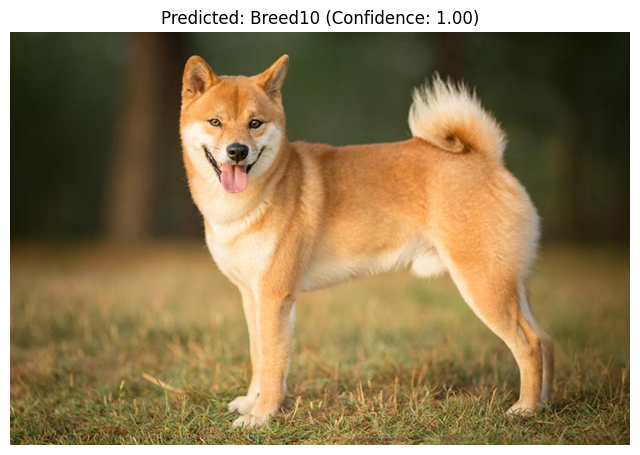

('Breed10', 0.998988926410675)

In [ ]:
# inference(model, "dog.jpg")